In [1]:
#can we find K34 while assuming basic values for the e and i parameters?
import copy
import numpy as np
import matplotlib.pyplot as p
import astropy.units as u
import funcs
import pickle

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [87]:
#Load lightcurve

lc = np.genfromtxt('Lightcurves/K34_clean_noecl.txt')
time = lc[:,0]+2454833
flux = lc[:,1]
err = lc[:,2]

In [95]:
# Kepler 34
cb = funcs.CBSystem(m1 = 1.0479,f1 = 1.,m2 = 1.0208,f2 = 0.8475,
                    ab = 0.22882,r1 = 1.1618 * u.Rsun.to('au'),r2 = 1.0927 * u.Rsun.to('au'),
                    eb = 0.52087,ib = np.deg2rad(89.8584),wb = 1.2468,
                    fb = 3.4675,
                    mp = 0.220 * u.Mjup.to('Msun'),ap = 1.0896,rp = 0.764 * u.Rjupiter.to('au'),ep = 0.182,
                    ip = np.deg2rad(90.355),wp = 0.1378,fp = 2.0623,
                    Wp = np.deg2rad(-1.74),
                    t0 = 2454969.2000)

cb.ap = 
ab0 = cb.ab
mb0 = cb.m1 + cb.m2
p_p0 = (cb.ap**3/(cb.m1+cb.m2))**(1./2.)*365.25 #in days
fp0 = cb.fp
print(1/np.sqrt( (cb.m1+cb.m2)/cb.ab**3 )*365.25)
print(p_p0)

timing_precision = 30./86400./365.25 * (2*np.pi)  #in years/2pi

t = time


27.7960087219
288.8298729659465


In [96]:
# make the reference stacked light curve set

#tts = funcs.reb_cb_c(cb,tmin=np.min(t),tmax=np.max(t))

tts,tds = funcs.reb_cb_dvm(cb,0,2,tmin=np.min(t),tmax=np.max(t), timing_precision=timing_precision)
    
ref_tts = tts[tds>0]
ref_tds = tds[tds>0]

tts_sec,tds_sec = funcs.reb_cb_dvm(cb,1,2,tmin=np.min(t),tmax=np.max(t), timing_precision=timing_precision)
    
ref_tts_sec = tts_sec[tds_sec>0]
ref_tds_sec = tds_sec[tds_sec>0]

In [62]:
#lightcurve statistic - transfer lightcurve to a varying duration statistic. 
#0.1d, 0.15d, 0.2d, .25d, .3d, .35d, 0.4d, .45d, .5d (not all useful for K16, but generally speaking will be)

windows = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
minpoints = 3
blurfactor = 1.0
#window lightcurve with duration
lcstat = {}
blurlcstat = {}
for win in windows:
    lcstat[win], blurlcstat[win] = funcs.running_mean_gaps(time,flux-1,win,minpoints,blurfactor)


<IPython.core.display.Javascript object>


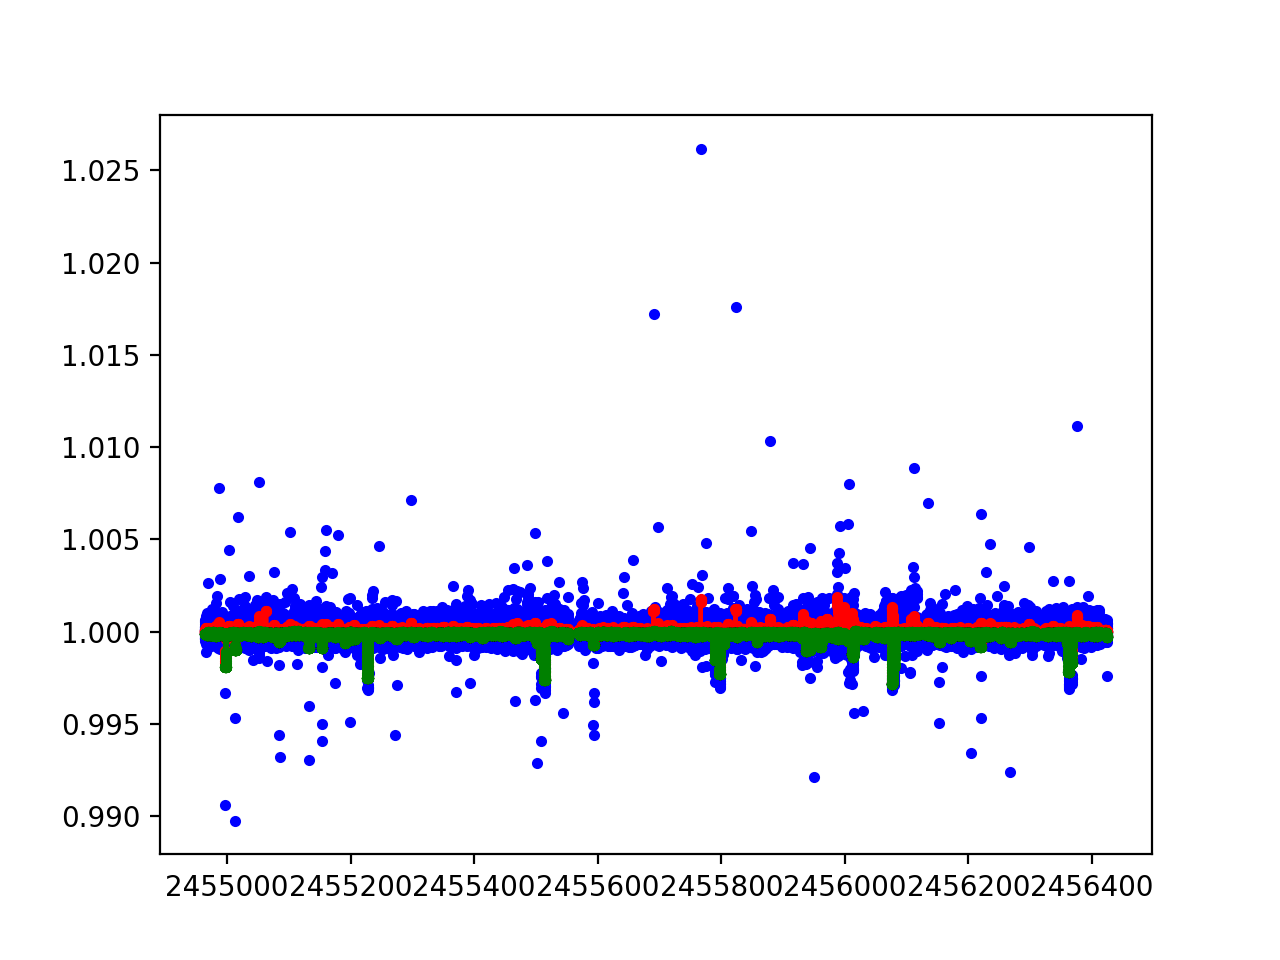

In [63]:
for win in windows:
    blurlcstat[win][blurlcstat[win]>500] = 0.
    lcstat[win][lcstat[win]>500] = 0.
p.figure()
p.plot(time,flux,'b.')
p.plot(time,lcstat[0.3]+1,'r.-')
p.plot(time,blurlcstat[0.3]+1,'g.-')
#p.ylim(0.975,1.01)

In [42]:
# Load nbody data (deserialize)
with open('k34-nbody.pkl', 'rb') as handle:
    #tts_all = pickle.load(handle)
    tts_all = pickle.load(handle)
    tds_all = pickle.load(handle)
#with open('K16_tds_all.pickle', 'rb') as handle:
#    tds_all = pickle.load(handle)



In [45]:
for pp in tts_all.keys():
    for fp in tts_all[pp].keys():
        if len(tts_all[pp][fp]) > np.ceil((time[-1]-time[0])/float(pp))+1:
            tts_all[pp][fp] = []
            

In [46]:
print(len(tts_all.keys()))
print(len(tts_all['130.0'].keys()))

2276
700


In [47]:
#define range over which to scan (needs to match that loaded. Could extract from dict keys
# but then lose precision
nbins = (1/130. - 1/500.) / (2.5e-6)
invppset = np.linspace(1/500.,1/130.,nbins)
ppset = 1./invppset[::-1] #uniform in frequency
fpset = np.linspace(0,2*np.pi,700)



/Users/davidarmstrong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


In [64]:
periodogram = funcs.make_periodogram(tts_all,tds_all,time,ppset,fpset,windows,blurlcstat)

<IPython.core.display.Javascript object>


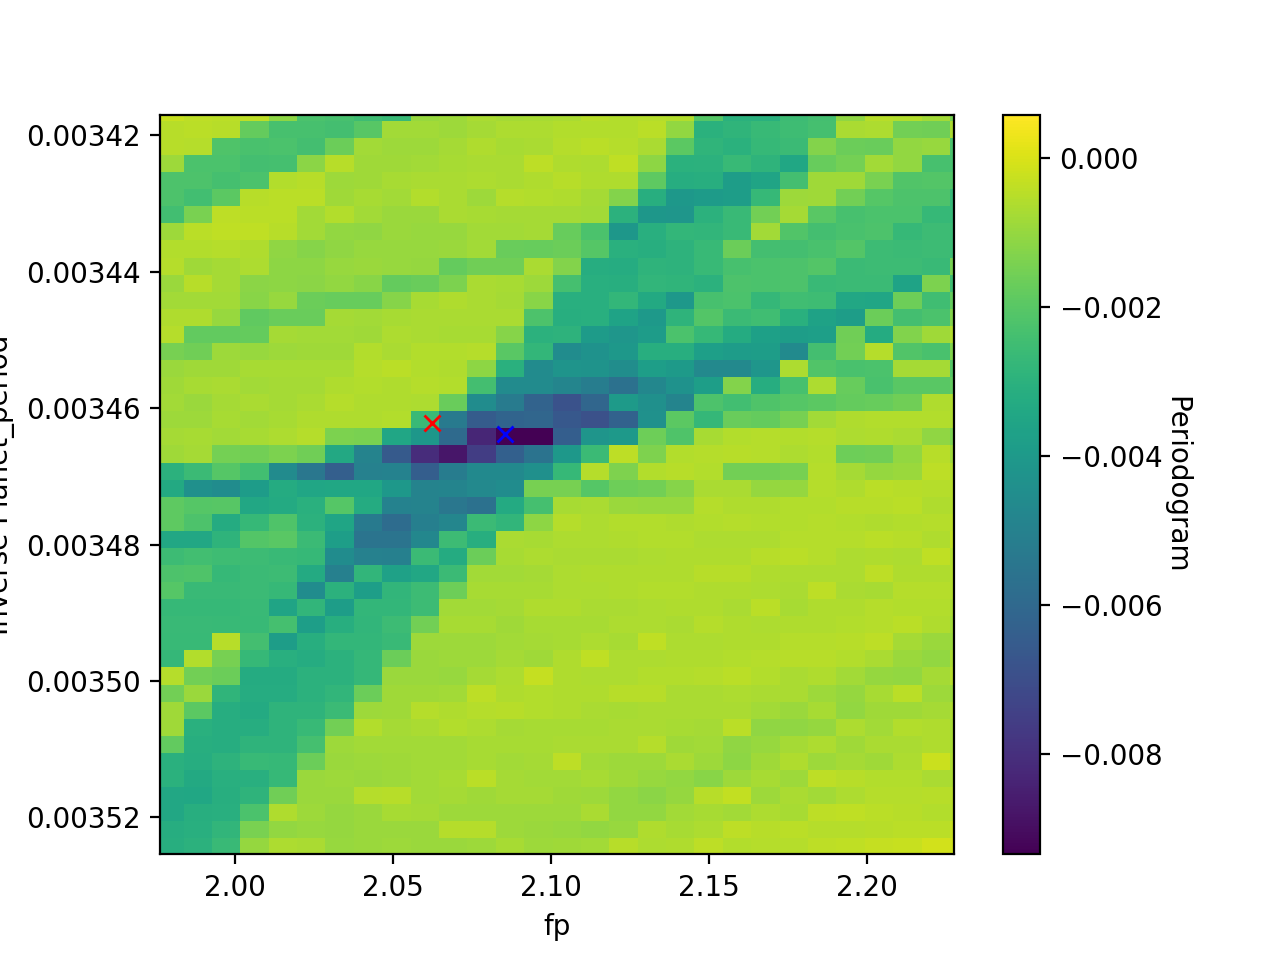

-0.00935246421315
-13.6541101934
[ 2455227.44432808  2455508.36300456  2455789.76440852  2456076.55615787
  2456367.26172691]


In [65]:
p.figure()
palette = p.cm.viridis
p.imshow(periodogram,origin='lower',
         extent=[np.min(fpset),np.max(fpset),1./np.min(ppset),1./np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Periodogram', rotation=270, labelpad=10)
p.ylabel('Inverse Planet_period')
p.xlabel('fp')
p.plot(fp0,1./p_p0,'rx')
print(np.min(periodogram))
print((np.min(periodogram)-np.mean(periodogram))/np.std(periodogram))
minidx = np.unravel_index(np.argmin(periodogram),(len(ppset),len(fpset)))
p.plot(fpset[minidx[1]],1./ppset[minidx[0]],'bx')
pp = ppset[minidx[0]]
fp = fpset[minidx[1]]

tts = tts_all[str(pp)[:6]][str(fp)[:6]]
print(tts)

In [66]:
blurlcstat_norm = funcs.normalise_stat(blurlcstat,lcstat,window=250)

In [67]:
periodogram_norm = funcs.make_periodogram(tts_all,tds_all,time,ppset,fpset,
                                             windows,blurlcstat_norm)

periodogram_norm_pertransit = funcs.make_periodogram_pertransit(tts_all,tds_all,time,
                                                                   ppset,fpset,windows,
                                                                   blurlcstat_norm)

<IPython.core.display.Javascript object>


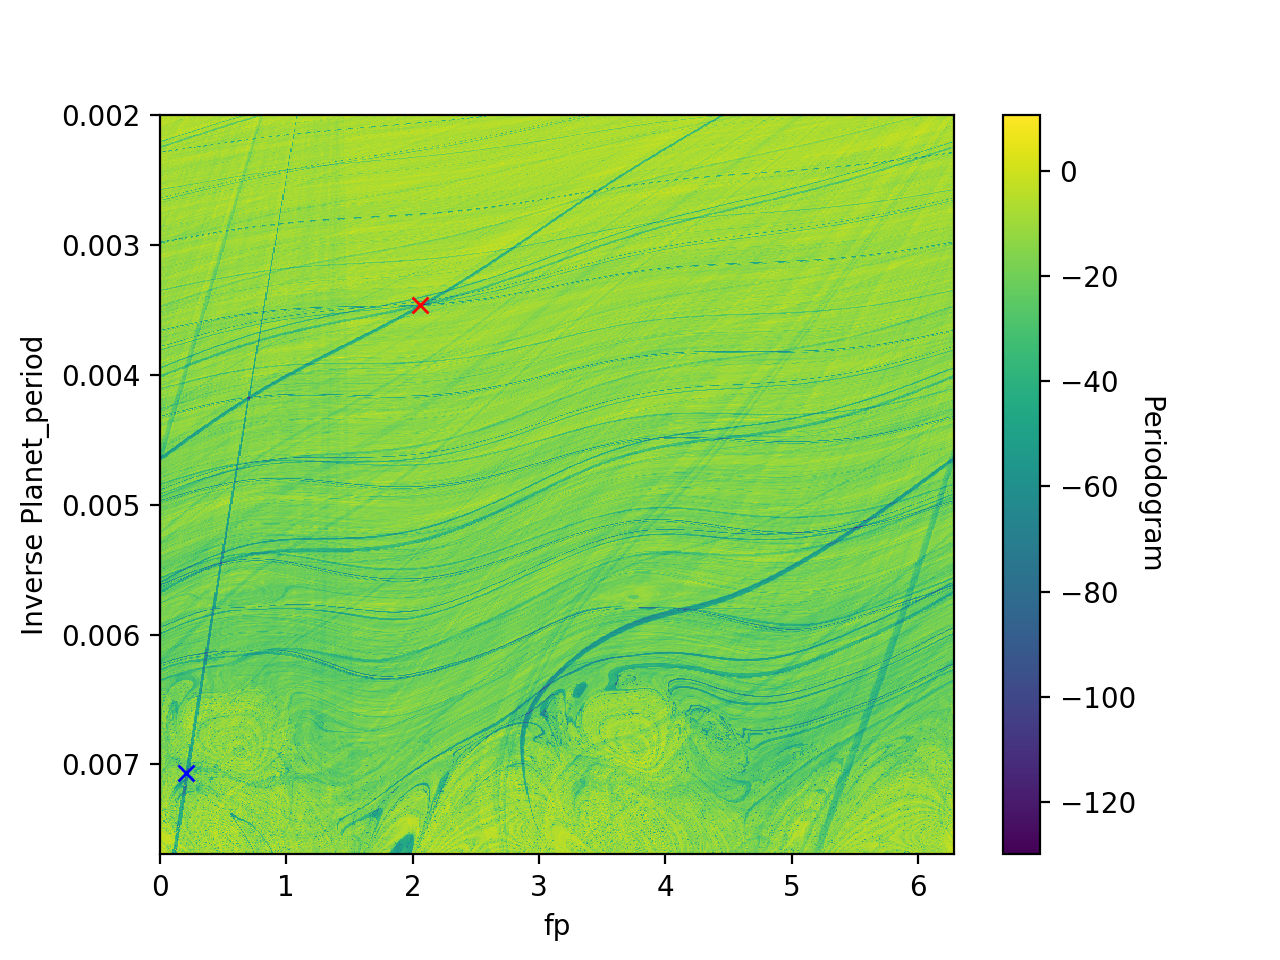

-130.025904049
-11.881364805


<IPython.core.display.Javascript object>


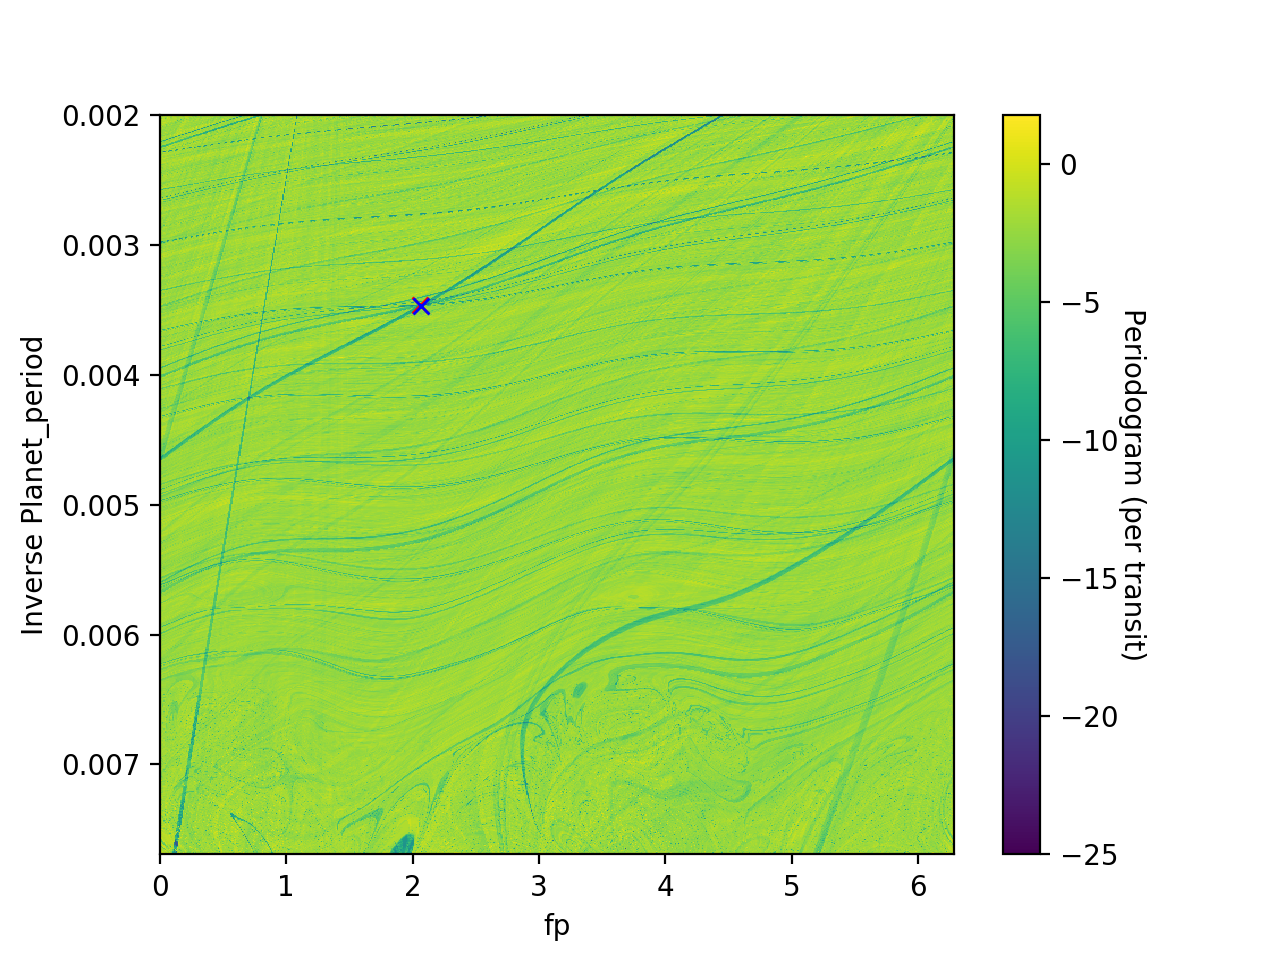

-25.0118104579
-18.4720210715


In [68]:
p.figure()
palette = p.cm.viridis
p.imshow(periodogram_norm,origin='lower',
         extent=[np.min(fpset),np.max(fpset),1./np.min(ppset),1./np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Periodogram', rotation=270, labelpad=10)
p.ylabel('Inverse Planet_period')
p.xlabel('fp')
p.plot(fp0,1./p_p0,'rx')
minidx = np.unravel_index(np.argmin(periodogram_norm),(len(ppset),len(fpset)))
p.plot(fpset[minidx[1]],1./ppset[minidx[0]],'bx')
print(np.min(periodogram_norm))
print((np.min(periodogram_norm)-np.mean(periodogram_norm))/np.std(periodogram_norm))

#p.figure()
#p.hist(periodogram_nt_norm,bins=100)

p.figure()
palette = p.cm.viridis
p.imshow(periodogram_norm_pertransit,origin='lower',
         extent=[np.min(fpset),np.max(fpset),1./np.min(ppset),1./np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Periodogram (per transit)', rotation=270, labelpad=10)
p.ylabel('Inverse Planet_period')
p.xlabel('fp')
p.plot(fp0,1./p_p0,'rx')
minidx_pt = np.unravel_index(np.argmin(periodogram_norm_pertransit),(len(ppset),len(fpset)))
p.plot(fpset[minidx_pt[1]],1./ppset[minidx_pt[0]],'bx')
print(np.min(periodogram_norm_pertransit))
print((np.min(periodogram_norm_pertransit)-np.mean(periodogram_norm_pertransit))/np.std(periodogram_norm_pertransit))


<IPython.core.display.Javascript object>


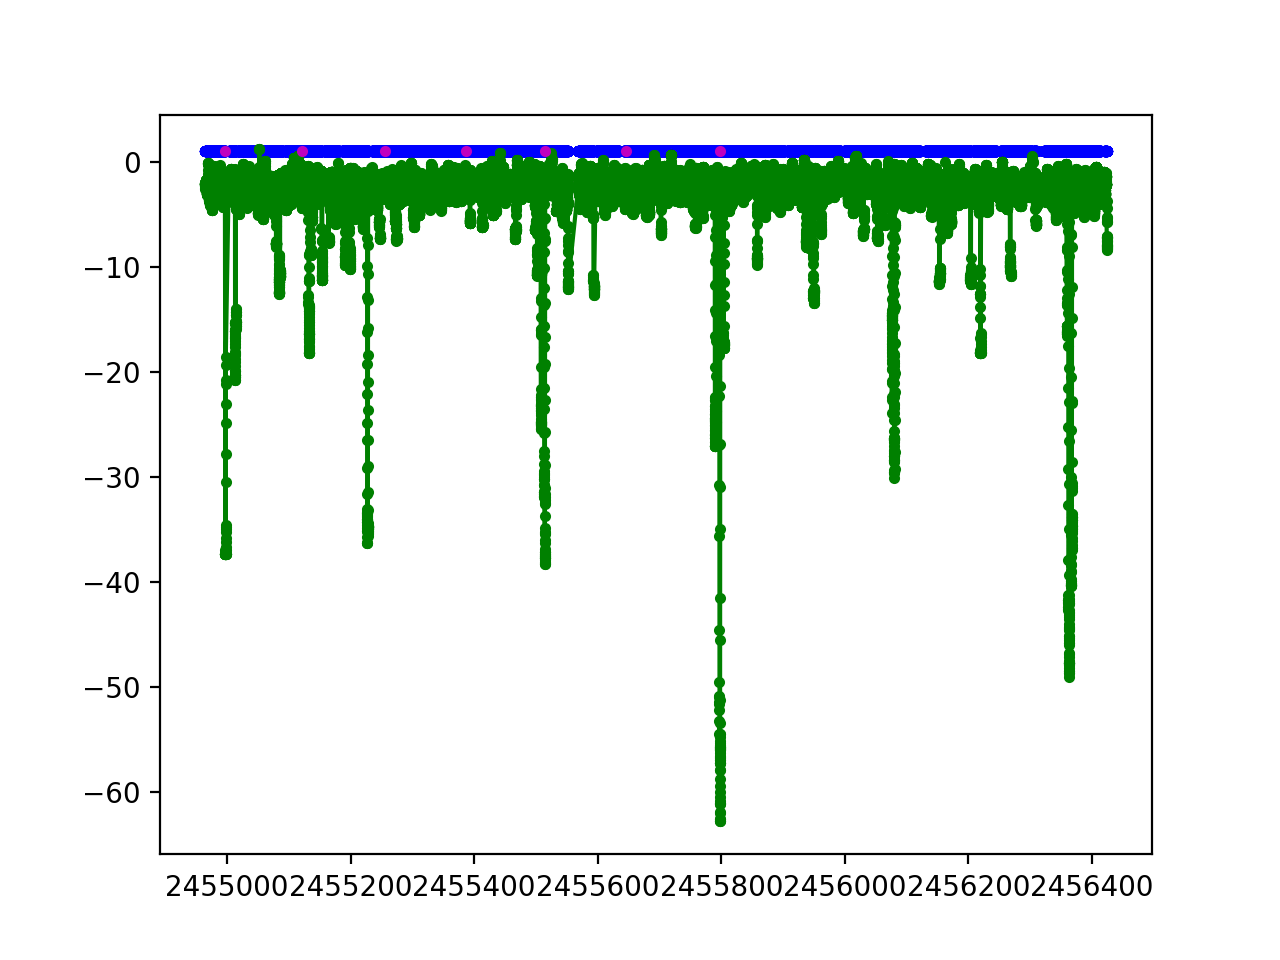

141.457091747


<IPython.core.display.Javascript object>


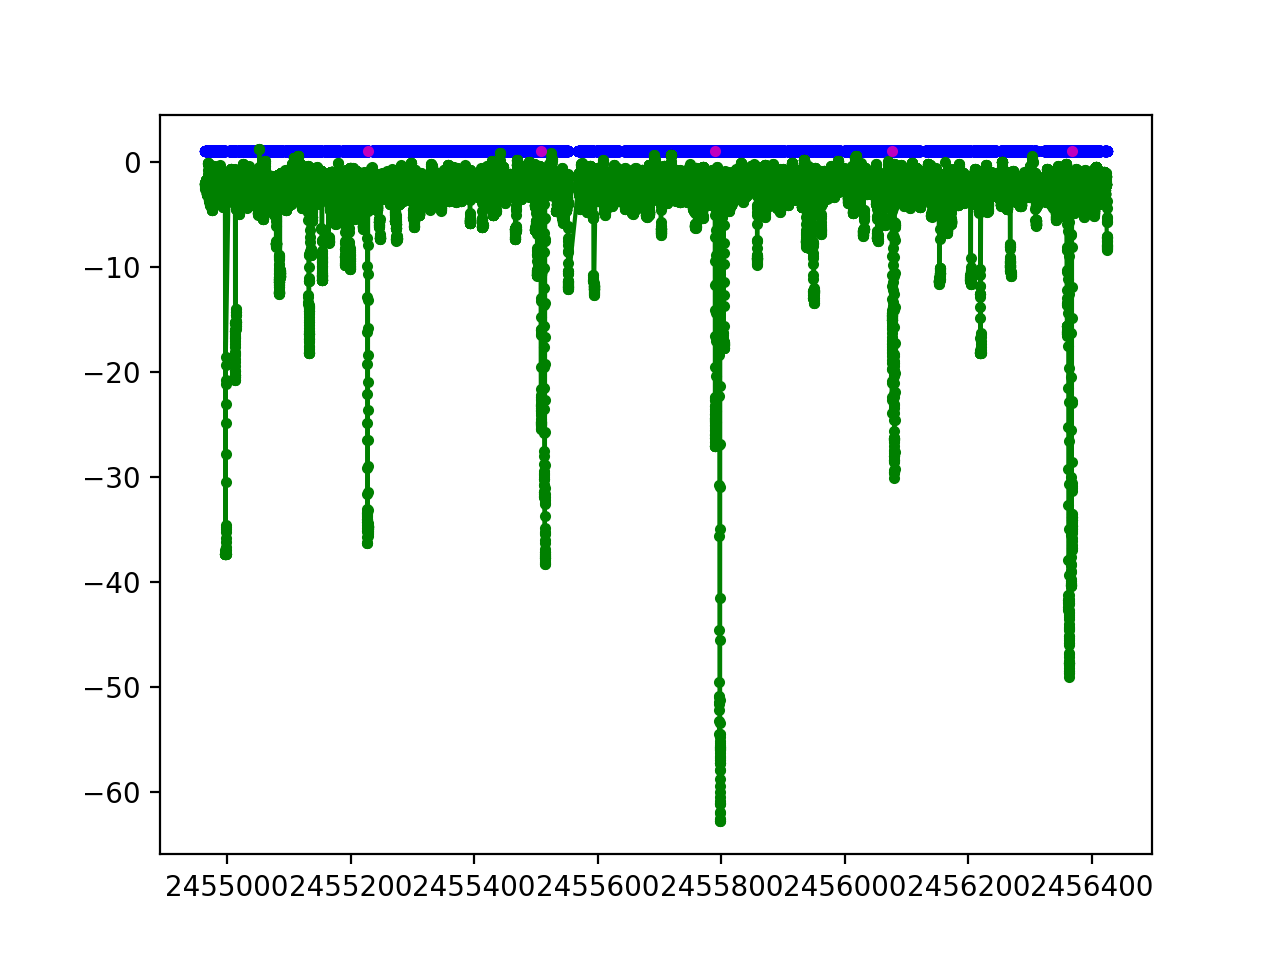

288.497180873


In [69]:
p.figure()
p.plot(time,flux,'b.')
p.plot(time,blurlcstat_norm[0.3],'g.-')

pp = ppset[minidx[0]]
fp = fpset[minidx[1]]
print(pp)

tts = tts_all[str(pp)[:6]][str(fp)[:6]]
tds = tds_all[str(pp)[:6]][str(fp)[:6]]

for transit,dur in zip(tts,tds):
    p.plot(transit,0.9985,'m.')
    #p.plot([transit-dur/2.,transit+dur/2.],[0.999,0.999])

#p.ylim(0.998,1.002)

p.figure()
p.plot(time,flux,'b.')
p.plot(time,blurlcstat_norm[0.3],'g.-')

pp = ppset[minidx_pt[0]]
fp = fpset[minidx_pt[1]]
print(pp)
tts = tts_all[str(pp)[:6]][str(fp)[:6]]
tds = tds_all[str(pp)[:6]][str(fp)[:6]]

for transit,dur in zip(tts,tds):
    p.plot(transit,0.9985,'m.')
    #p.plot([transit-dur/2.,transit+dur/2.],[0.999,0.999])

#p.ylim(0.998,1.002)

<IPython.core.display.Javascript object>


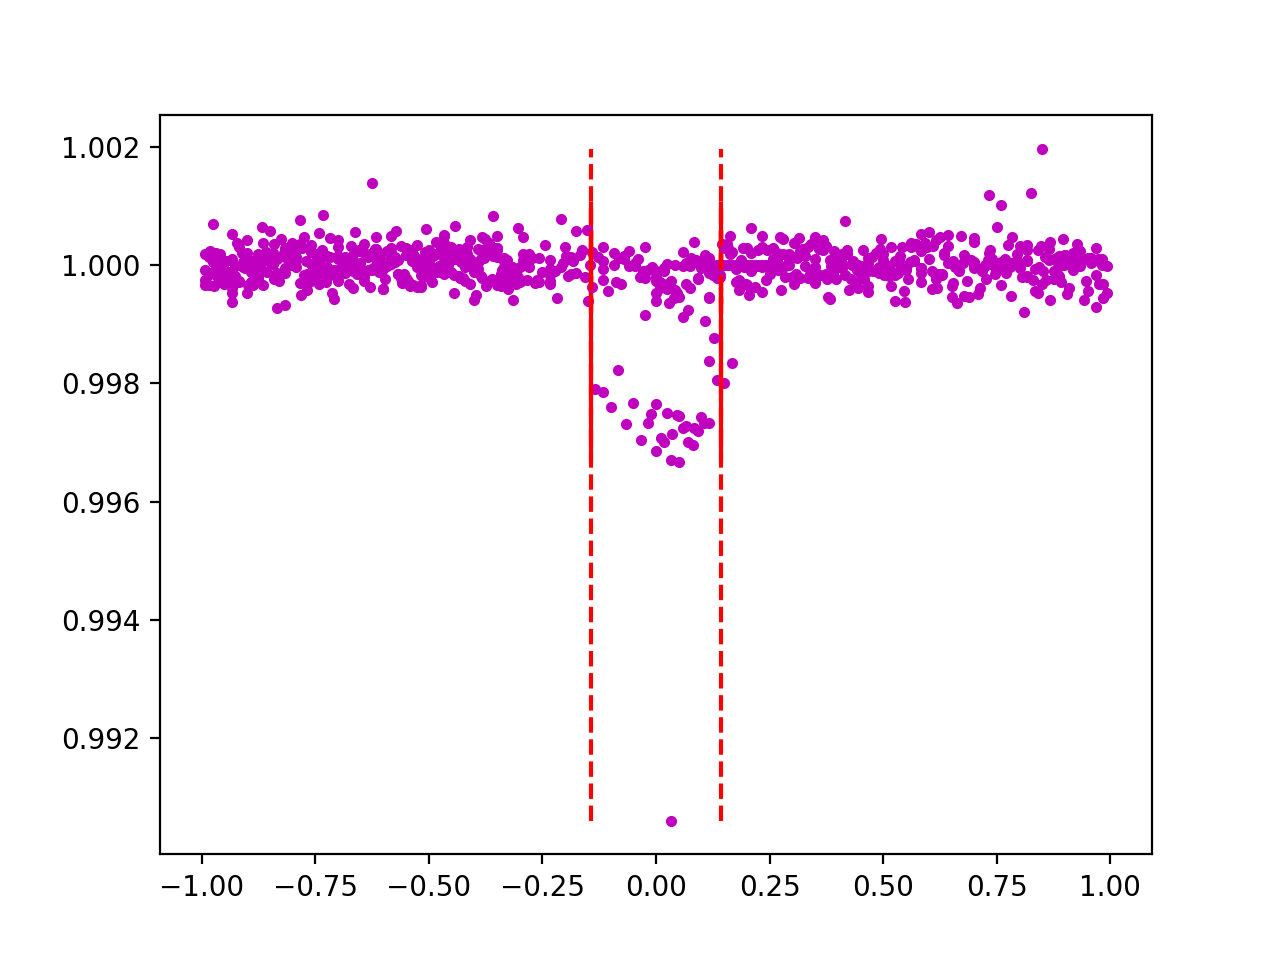

In [70]:
pp = ppset[minidx[0]]
fp = fpset[minidx[1]]

tts = tts_all[str(pp)[:6]][str(fp)[:6]]
tds = tds_all[str(pp)[:6]][str(fp)[:6]]
p.figure()

for transit,dur in zip(tts,tds):
    #what's the window and blur window?
    blurfactor = 1.5 #1.5 means a 3 duration window is scanned
    minpoints = 3
    
    time_window, flux_window, timescale = funcs.extract_transit_window(transit,dur,time,
                                                                       flux,windows,
                                                                       minpoints,blurfactor)             
    if len(time_window)>0:
        p.plot(timescale,flux_window,'m.')
        p.plot([-1/7.,-1/7.],[np.min(flux_window),np.max(flux_window)],'r--')
        p.plot([1/7.,1/7.],[np.min(flux_window),np.max(flux_window)],'r--')


<IPython.core.display.Javascript object>


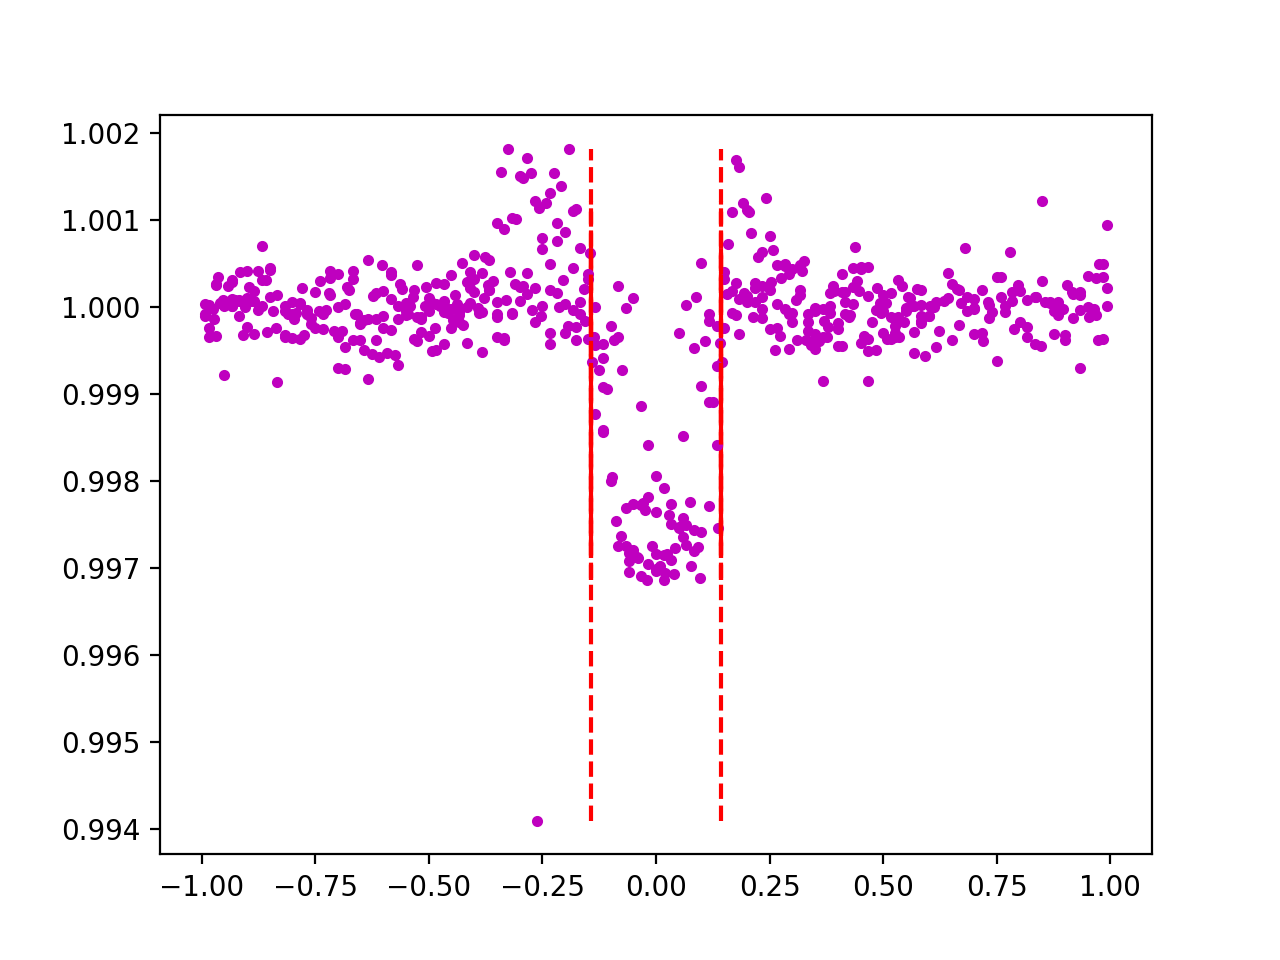

In [71]:
pp = ppset[minidx_pt[0]]
fp = fpset[minidx_pt[1]]

tts = tts_all[str(pp)[:6]][str(fp)[:6]]
tds = tds_all[str(pp)[:6]][str(fp)[:6]]
p.figure()

for transit,dur in zip(tts,tds):
    #what's the window and blur window?
    blurfactor = 1.5 #1.5 means a 3 duration window is scanned
    minpoints = 3
    
    time_window, flux_window, timescale = funcs.extract_transit_window(transit,dur,time,
                                                                       flux,windows,
                                                                       minpoints,blurfactor)             
    if len(time_window)>0:
        p.plot(timescale,flux_window,'m.')
        p.plot([-1/7.,-1/7.],[np.min(flux_window),np.max(flux_window)],'r--')
        p.plot([1/7.,1/7.],[np.min(flux_window),np.max(flux_window)],'r--')


<IPython.core.display.Javascript object>


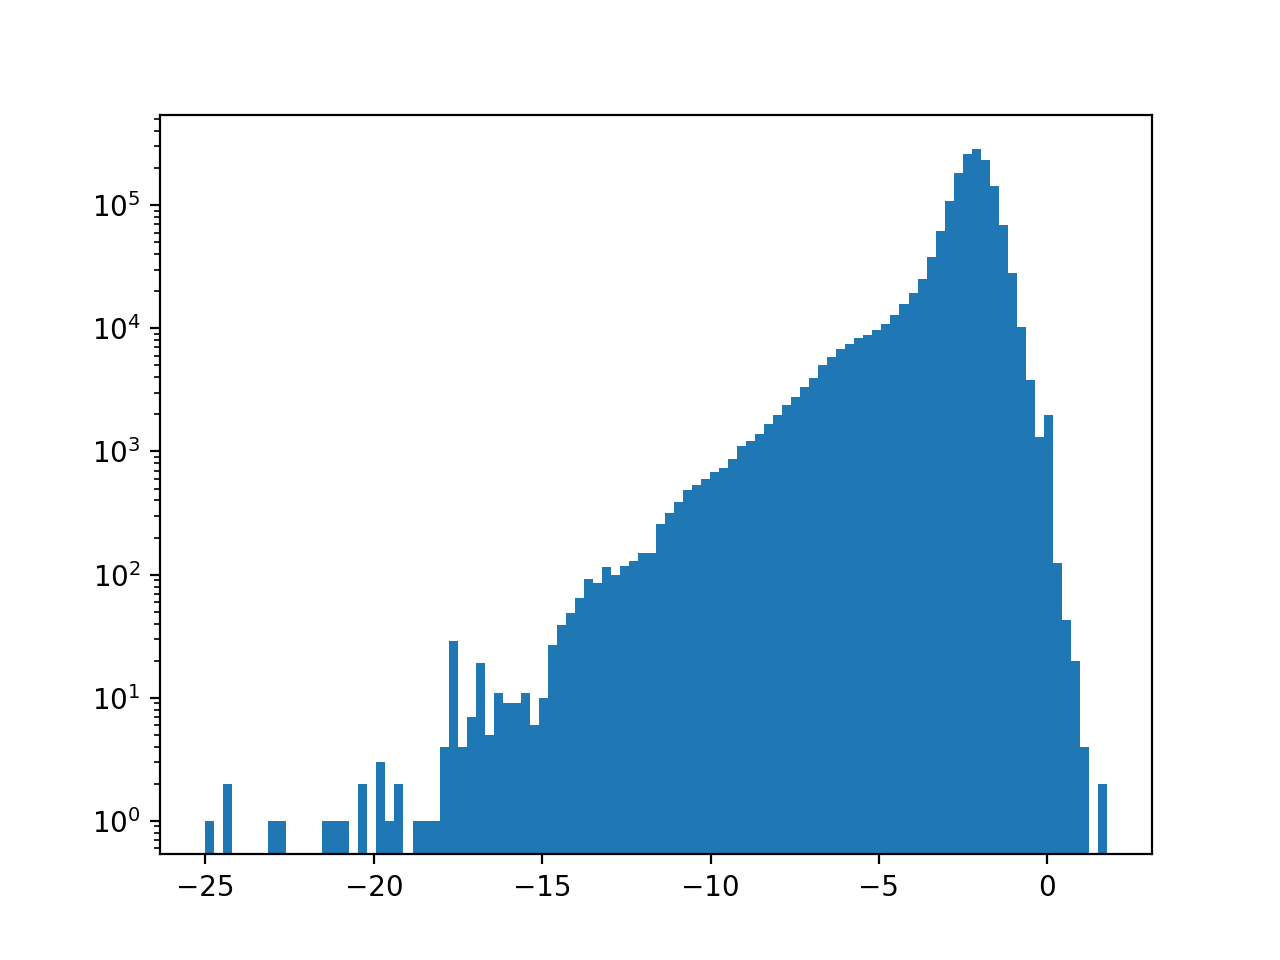

In [72]:
p.figure()
p.hist(periodogram_norm_pertransit.flatten(),bins=100)
p.yscale('log', nonposy='clip')

<IPython.core.display.Javascript object>


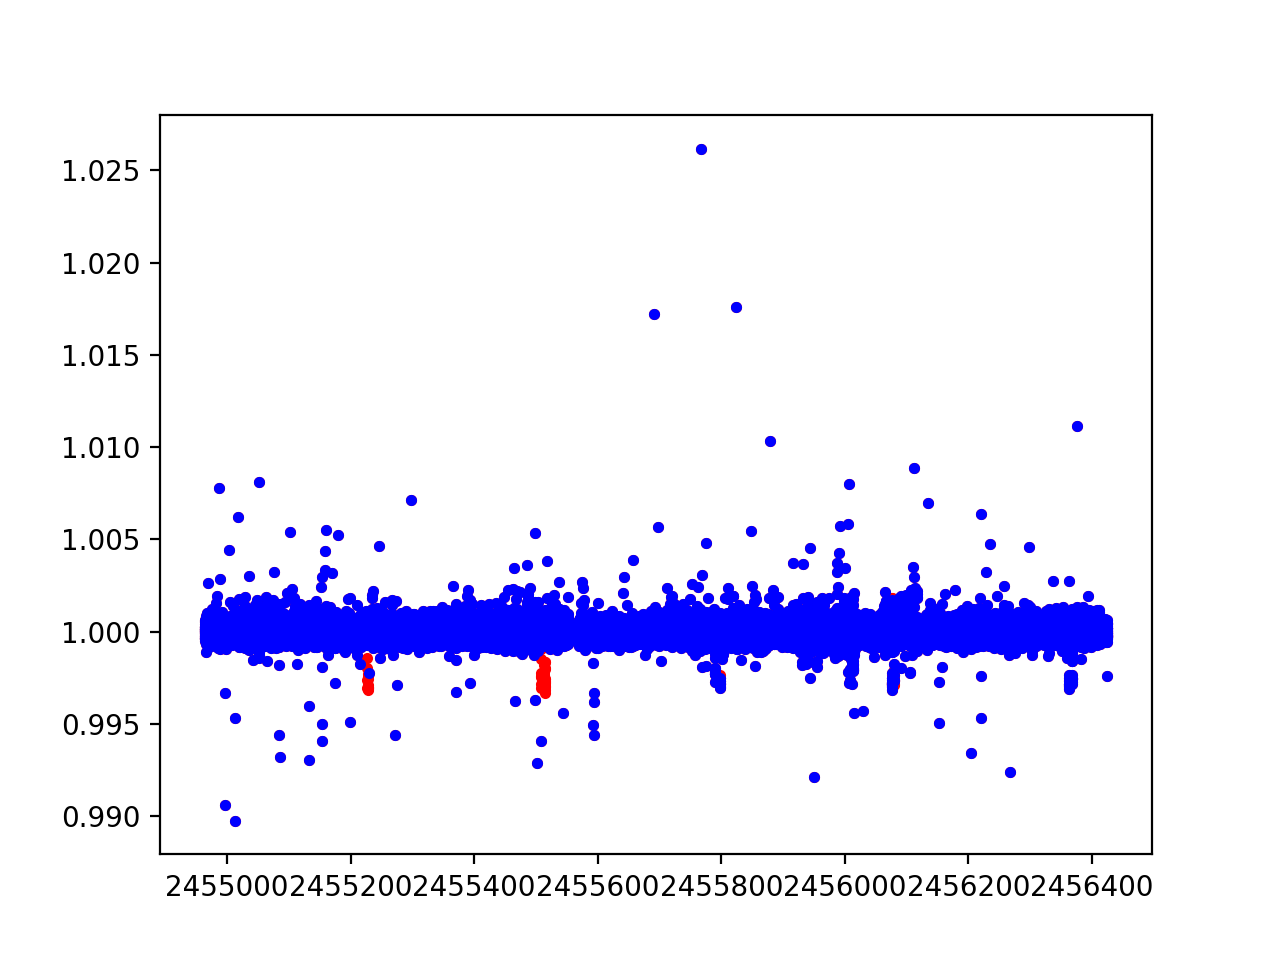

In [97]:
time_nt = time.copy()
flux_nt = flux.copy()
err_nt = err.copy()

for transit,dur in zip(ref_tts,ref_tds):
    tmin = transit - 3*dur/4. #bit of extra leeway here
    tmax = transit + 3*dur/4.
    cut = (time_nt>tmin) & (time_nt<tmax)
    time_nt, flux_nt, err_nt = time_nt[~cut], flux_nt[~cut], err_nt[~cut]

for transit,dur in zip(ref_tts_sec,ref_tds_sec):
    tmin = transit - 3*dur/4. #bit of extra leeway here
    tmax = transit + 3*dur/4.
    cut = (time_nt>tmin) & (time_nt<tmax)
    time_nt, flux_nt, err_nt = time_nt[~cut], flux_nt[~cut], err_nt[~cut]

p.figure()
p.plot(time,flux,'r.')
p.plot(time_nt,flux_nt,'b.')

output = np.array([time,flux,err]).T
np.savetxt('Lightcurves/K34_cln_noecl_notran.txt',output)


In [80]:
#try without K16b transits
lc_notran = np.genfromtxt('Lightcurves/K34_cln_noecl_notran.txt')
time_nt = lc_notran[:,0]
flux_nt = lc_notran[:,1]
err_nt = lc_notran[:,2]

#outlier cut
#cutidx = funcs.outlier_cut(time_nt,flux_nt,10, 250)
#time_nt_cut, flux_nt_cut = time_nt[cutidx],flux_nt[cutidx]
time_nt_cut, flux_nt_cut = time_nt, flux_nt

windows = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
minpoints = 3
blurfactor = 1.0
#window lightcurve with duration
lcstat_nt = {}
blurlcstat_nt = {}
for win in windows:
    lcstat_nt[win], blurlcstat_nt[win] = funcs.running_mean_gaps(time_nt_cut,flux_nt_cut-1,win,minpoints,blurfactor)
    
blurlcstat_nt_norm = funcs.normalise_stat(blurlcstat_nt,lcstat_nt,window=250)

In [83]:
for win in windows:
    blurlcstat_nt_norm[win][blurlcstat_nt[win]>500] = 0.
    blurlcstat_nt[win][blurlcstat_nt[win]>500] = 0.
    lcstat_nt[win][lcstat_nt[win]>500] = 0.

In [84]:
periodogram_nt = funcs.make_periodogram(tts_all,tds_all,time_nt_cut,ppset,fpset,windows,blurlcstat_nt_norm)
periodogram_nt_pt = funcs.make_periodogram_pertransit(tts_all,tds_all,time_nt_cut,ppset,fpset,windows,blurlcstat_nt_norm)

<IPython.core.display.Javascript object>


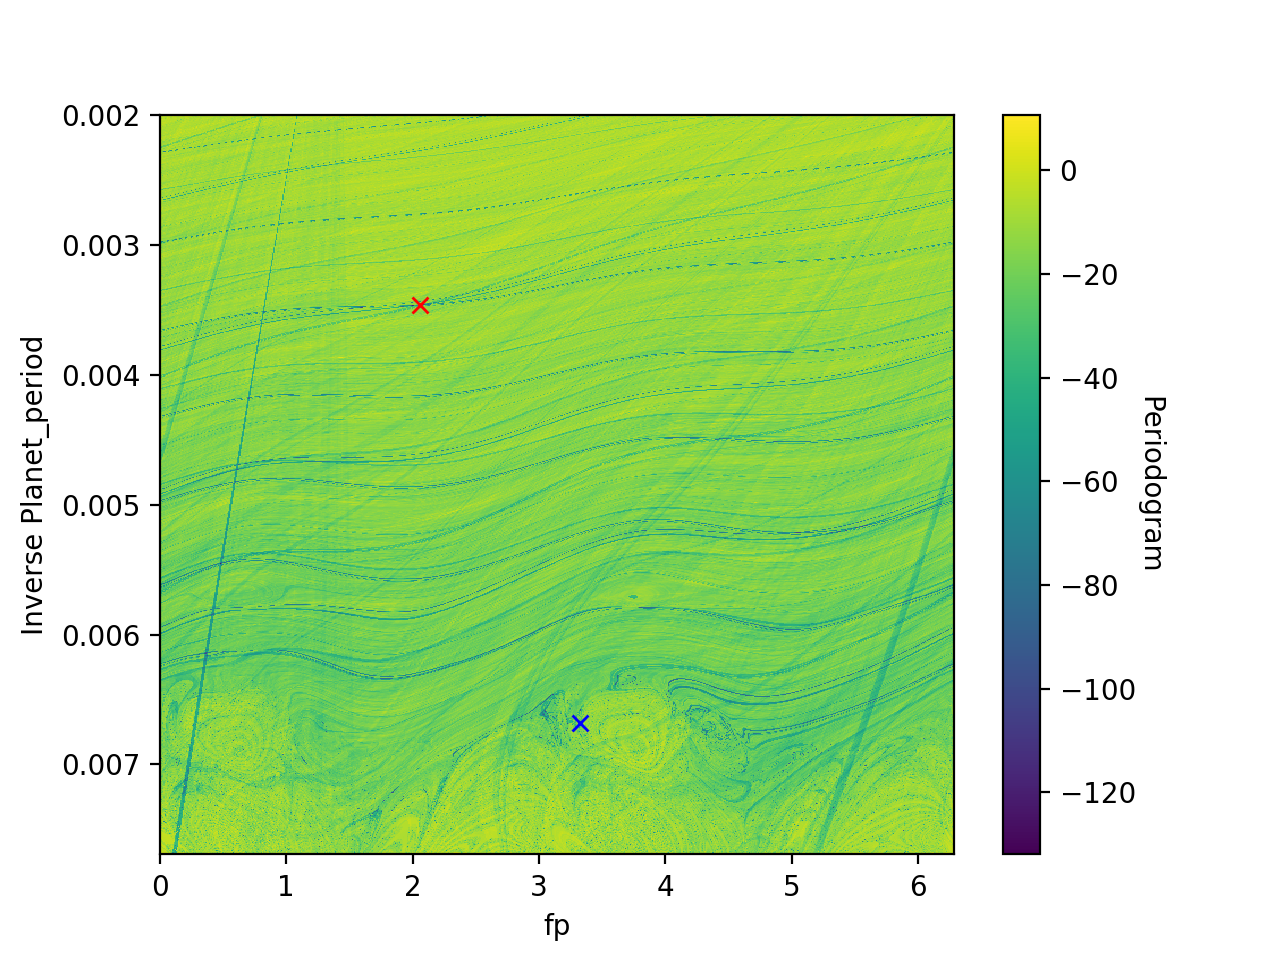

-131.958585796
-12.3464107841


<IPython.core.display.Javascript object>


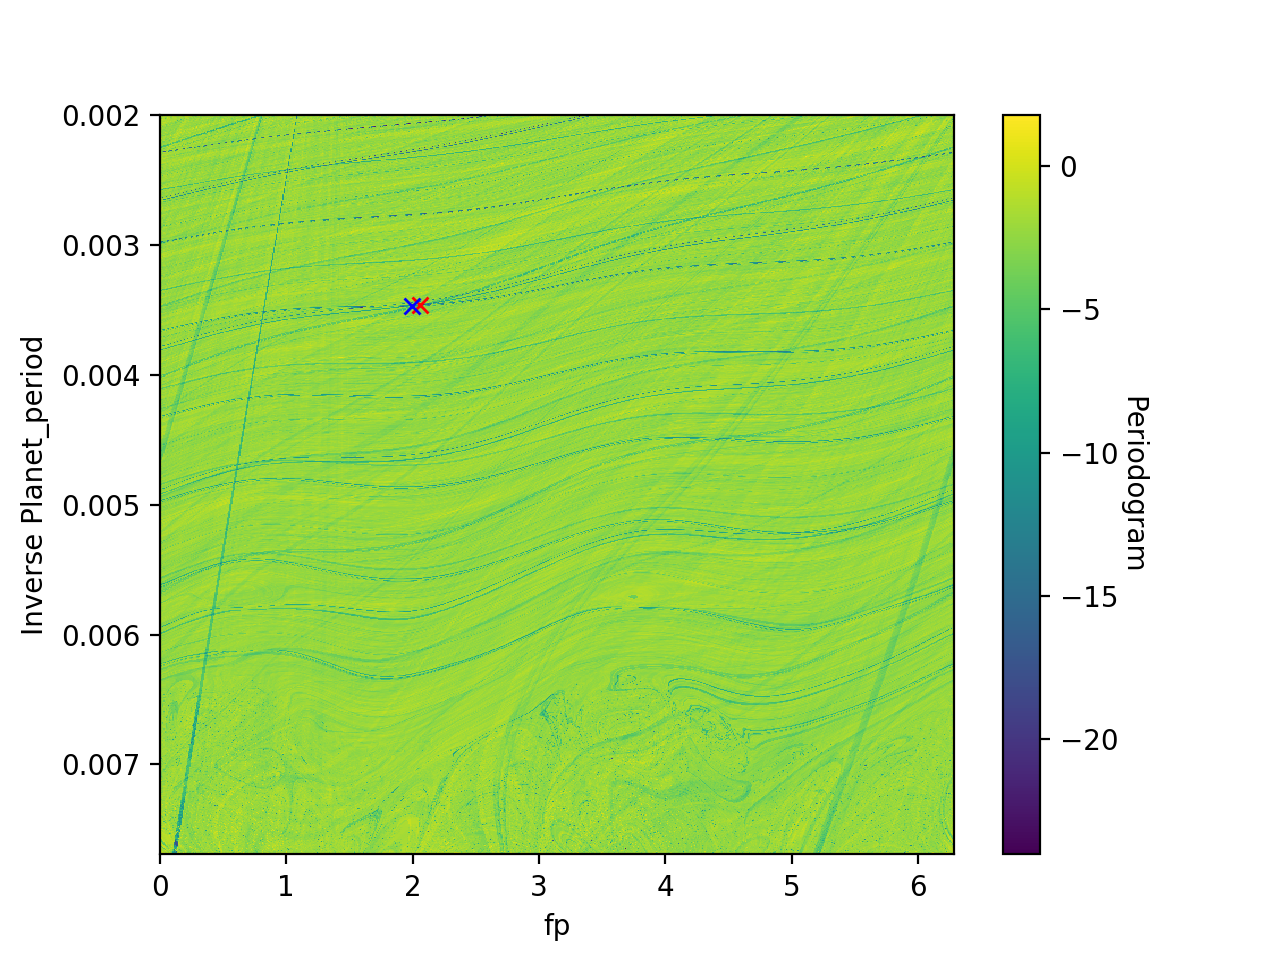

-24.0248243669
-17.8447741705


In [86]:
p.figure()
palette = p.cm.viridis
p.imshow(periodogram_nt,origin='lower',
         extent=[np.min(fpset),np.max(fpset),1./np.min(ppset),1./np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Periodogram', rotation=270, labelpad=10)
p.ylabel('Inverse Planet_period')
p.xlabel('fp')
p.plot(fp0,1./p_p0,'rx')
minidx = np.unravel_index(np.argmin(periodogram_nt),(len(ppset),len(fpset)))
p.plot(fpset[minidx[1]],1./ppset[minidx[0]],'bx')
print(np.min(periodogram_nt))
print((np.min(periodogram_nt)-np.mean(periodogram_nt))/np.std(periodogram_nt))

p.figure()
palette = p.cm.viridis
p.imshow(periodogram_nt_pt,origin='lower',
         extent=[np.min(fpset),np.max(fpset),1./np.min(ppset),1./np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Periodogram', rotation=270, labelpad=10)
p.ylabel('Inverse Planet_period')
p.xlabel('fp')
p.plot(fp0,1./p_p0,'rx')
minidx_pt = np.unravel_index(np.argmin(periodogram_nt_pt),(len(ppset),len(fpset)))
p.plot(fpset[minidx_pt[1]],1./ppset[minidx_pt[0]],'bx')
print(np.min(periodogram_nt_pt))
print((np.min(periodogram_nt_pt)-np.mean(periodogram_nt_pt))/np.std(periodogram_nt_pt))


<IPython.core.display.Javascript object>


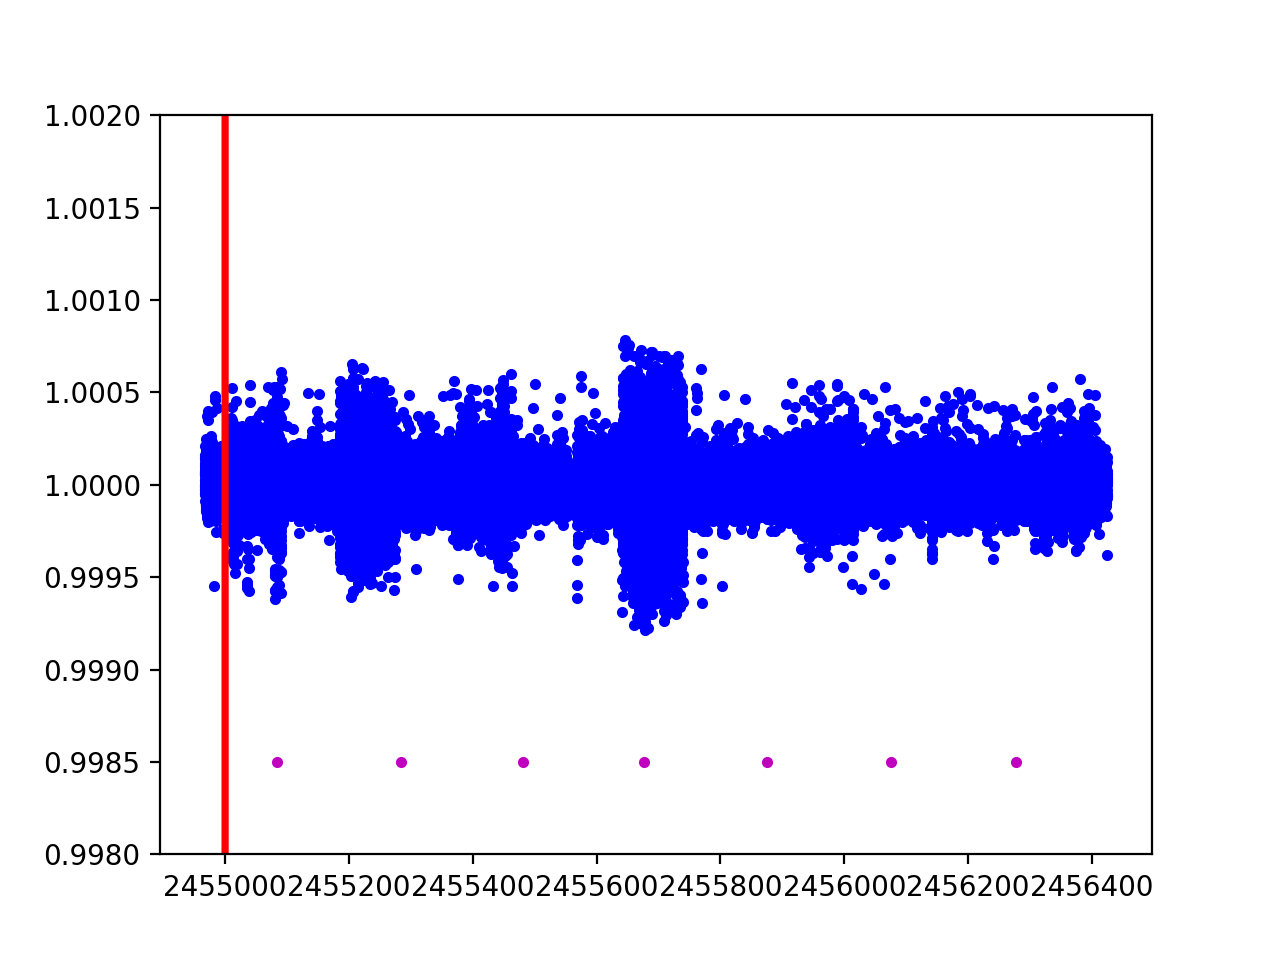

(0.998, 1.002)

In [131]:
p.figure()
p.plot(time_nt_cut,flux_nt_cut,'b.')
p.plot(time_nt_cut,lcstat_nt[0.3],'r.-')
p.plot(time_nt_cut,blurlcstat_nt[0.3],'g.-')

pp = ppset[minidx_pt[0]]
fp = fpset[minidx_pt[1]]

tts = tts_all[str(pp)[:6]][str(fp)[:6]]
tds = tds_all[str(pp)[:6]][str(fp)[:6]]

for transit,dur in zip(tts,tds):
    p.plot(transit,0.9985,'m.')
    #p.plot([transit-dur/2.,transit+dur/2.],[0.999,0.999])

p.ylim(0.998,1.002)